In [1]:
import os 
import numpy as np
import tensorflow as tf
import pandas as pd 
import cv2
from tensorflow.keras.preprocessing import image
from glob import glob
import matplotlib.pyplot as plt

dataset_path = '/home/azureuser/cloudfiles/code/Users/samarth.tandon/experiment_2/dataset/'

denoise_path = os.path.join(dataset_path,'denoised_images')
denoise_imgs = glob(denoise_path+'/*.jpeg')

# create Noised images
noised_path = os.path.join(dataset_path,'noised_images')
if not os.path.isdir(noised_path):
    os.mkdir(noised_path)
noised_imgs= glob(noised_path+'/*.jpeg')


In [2]:
def load_image (img_path):
    img = image.load_img(img_path,target_size=(256,256))
    img = image.img_to_array(img).astype(np.float32)
    img = img/255.0
    return img

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(20, 20)
    for i in range(5,10):
        img_path = dataset[np.random.randint(0,len(dataset))]
        img = load_image(img_path)
        ax[i-5].imshow(img)
    plt.show()

# create noise_image 
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.17
    return noisy

def get_sample_image(input_images,target_images,target_shape=(256,256)):
    index = np.random.randint(0,len(input_images)) 
    image_name = input_images[index]
    mask_name = target_images[index]

    input_image = load_image(image_name)
    mask_image = load_image(mask_name)
    
    return input_image,mask_image

def display_predictions(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(8,7))
    axs[2].imshow(mask)
    axs[2].set_title('Predicted')
    axs[1].imshow(groud_truth)
    axs[1].set_title('GroundTruth')
    axs[0].imshow(img)
    axs[0].set_title('Input Image')
    plt.show()
    return 0

if len(os.listdir(noised_path)) ==0 :
    for img_path in denoise_imgs:
        img = load_image(img_path)
        noise_img = add_noice(img)
        cv2.imwrite(os.path.join(noised_path,os.path.basename(img_path)),noise_img*255)

In [3]:
import splitfolders
split_ratio = 0.75

train_path = os.path.join(dataset_path,'train')
val_path = os.path.join(dataset_path,'val')

if not os.path.isdir(train_path):
    splitfolders.ratio(dataset_path, output=dataset_path, seed=1337,
                            ratio=(split_ratio, 1 - split_ratio), group_prefix=None)

In [4]:
train_denoised = glob(os.path.join(train_path,'denoised_images')+'/*.jpeg')
train_noised = glob(os.path.join(train_path,'noised_images')+'/*.jpeg')

train_noised.sort()
train_denoised.sort()
print("training de-noised images :",len(train_denoised))
print("training noised images :",len(train_noised))

val_denoised = glob(os.path.join(val_path,'denoised_images')+'/*.jpeg')
val_noised = glob(os.path.join(val_path,'noised_images')+'/*.jpeg')
val_denoised.sort()
val_noised.sort()
print("training de-noised images :",len(val_denoised))
print("training noised images :",len(val_noised))

training de-noised images : 677
training noised images : 677
training de-noised images : 226
training noised images : 226


Displaying Real Images 


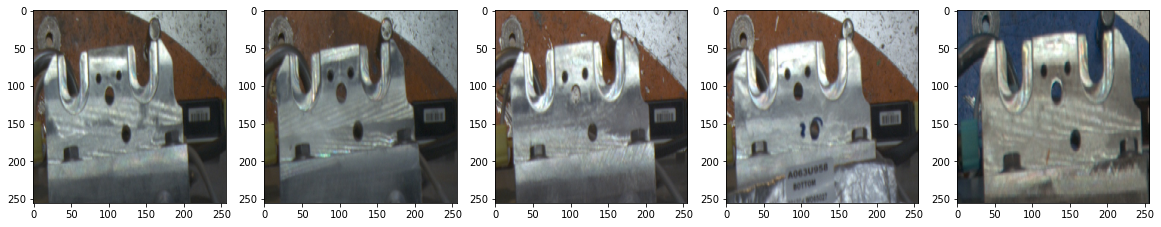

Noisy Images 


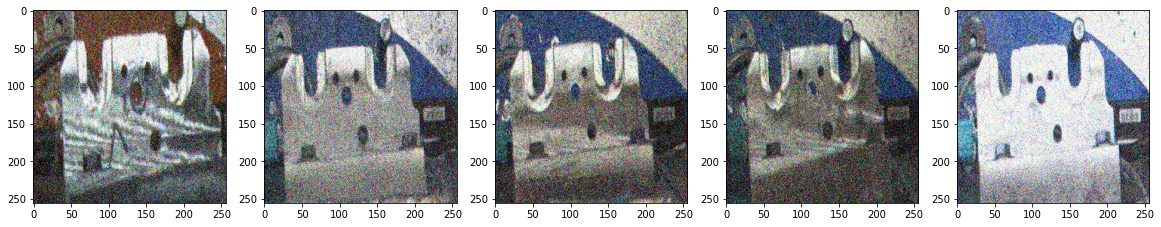

In [5]:
print("Displaying Real Images ")
show_img(train_denoised)

print("Noisy Images ")
show_img(train_noised)

In [6]:
from sklearn import utils as skutils 
from sklearn.utils import shuffle
import warnings
from tensorflow.keras.utils import Sequence
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
class DataGenerator(Sequence):
    def __init__(self, input_image,output_image, 
                 batch_size=1, image_size=256,
                 suffle=True,augmentation=False):
        self.image_filenames = input_image
        self.mask_names = output_image
        self.batch_size = batch_size
        self.image_shape = (image_size,image_size)
        self.indexes = None
        self.suffle = suffle

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
    
    def read_image_mask(self, image_name, mask_name):
        input_image = image.load_img(image_name,target_size=self.image_shape)
        mask_image = image.load_img(mask_name,target_size=self.image_shape)
        
        input_image = image.img_to_array(input_image).astype(np.float32)
        mask_image = image.img_to_array(mask_image).astype(np.float32)
        
        input_image = input_image/255.0
        mask_image = mask_image/255.0
        return input_image,mask_image
    
    def __getitem__(self, index):
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]
        this_batch_size = len(indexes) # The last batch can be smaller than the others

        # Defining dataset
        X = np.empty((this_batch_size, self.image_shape[0], self.image_shape[1], 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_shape[0], self.image_shape[1], 3), dtype=np.float32)
        for i, sample_index in enumerate(indexes):
            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
            if self.batch_size ==1:
                X_sample = np.reshape(X_sample,(1, X_sample.shape[0], X_sample.shape[1], 3))
                y_sample = np.reshape(y_sample,(1, y_sample.shape[0], y_sample.shape[1], 3))
                return X_sample,y_sample
            else:
                X[i,...] = X_sample
                y[i,...] = y_sample
            return X,y
            

(1, 256, 256, 3)


<Figure size 720x720 with 0 Axes>

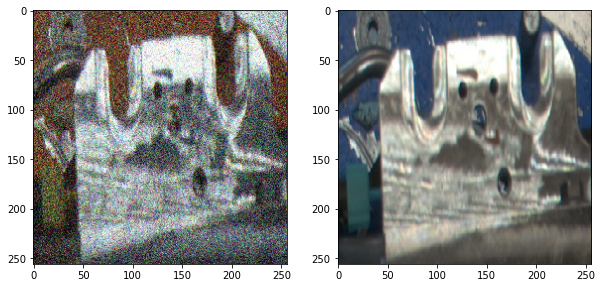

In [8]:
train_generator = DataGenerator( input_image= train_noised,image_size=256,
                                output_image = train_denoised, 
                                batch_size=1,augmentation=False)

test_generator = DataGenerator(input_image= val_noised,image_size=256,
                               output_image= val_denoised,batch_size=1,augmentation=False)

plt.figure(figsize=(10,10))
count = 0

f, ax = plt.subplots(1,2)
f.set_size_inches(10, 10)

Xtest, ytest = train_generator.__getitem__(np.random.randint(0,32))
print(Xtest.shape)
ax[0].imshow(Xtest[0])
ax[1].imshow(ytest[0])
plt.show()                 

## Generating Model for noise improvement  

In [9]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,concatenate
from tensorflow.keras.layers import Dropout,MaxPooling2D,Input,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping ,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [10]:
EPOCHS = 20
BATCH_SIZE= 1
IMG_SHAPE = (256,256,3)

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(n_filters = 16, dropout = 0.1, batchnorm = True,image_shape=(512,512,3)):
    # Contracting Path
    in_src_image = Input(shape=image_shape)
    c1 = conv2d_block(in_src_image, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[in_src_image], outputs=[outputs])
    return model

unet = get_unet(image_shape=IMG_SHAPE)

unet.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                    loss=tf.keras.losses.mse, metrics=['mse'])

In [11]:
# define Display Call abck 
class Display_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if (epoch+1)%10 ==0 :
            input_img, mask_img = get_sample_image(val_noised,val_denoised)
            predicted_img = unet.predict(np.expand_dims(input_img,axis=0))
            predicted_img = np.reshape(predicted_img,(predicted_img.shape[1],predicted_img.shape[2],3))
            display_predictions(predicted_img,mask_img,input_img)
            print("Displayinng results at: {}".format(epoch+1))

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               patience=5,verbose =1,
                               min_lr=0.1e-5)

# save Model
checkpoint = ModelCheckpoint("denoising_unet.h5", monitor='val_mse',
                             verbose=1, save_best_only=True, mode='low',period=5)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=5, verbose=1, mode = 'auto') 

callbacks = [checkpoint, lr_reducer,Display_callback()]

In [12]:
history = unet.fit(train_generator,
                  epochs=EPOCHS,steps_per_epoch=200,
                  validation_data = test_generator, 
                  verbose = 1, callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 32s 158ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 2/20
200/200 [==============================] - 29s 147ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/20
200/200 [==============================] - 29s 144ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/20
200/200 [==============================] - 29s 144ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/20
200/200 [==============================] - ETA: 0s - loss: 0.0088 - mse: 0.0088
Epoch 00005: val_mse improved from inf to 0.00413, saving model to denoising_unet.h5
200/200 [==============================] - 29s 147ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/20
200/200 [==============================] - 29s 145ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 7/20
200/200 [=====

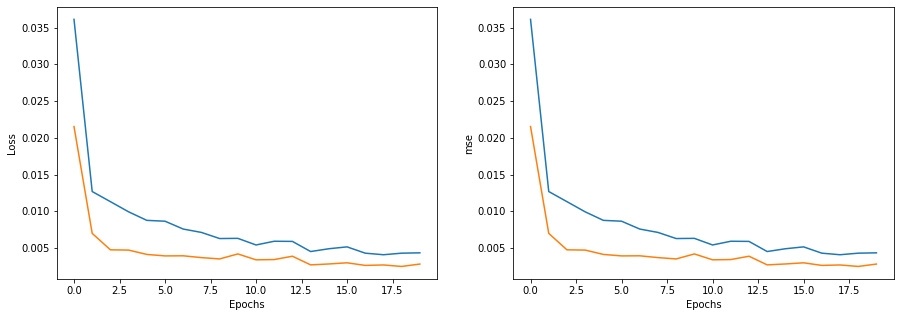

In [15]:
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_xlabel("Epochs");ax_loss.set_ylabel("Loss")

    ax_acc.plot(history.epoch, history.history["mse"], label="Train loss")
    ax_acc.plot(history.epoch, history.history["val_mse"], label="Validation loss")
    ax_acc.set_xlabel("Epochs");ax_acc.set_ylabel("mse")
plot_training_history(history)

In [18]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


noise_img, org_img = get_sample_image(val_noised,val_denoised)

value1 = PSNR(org_img, noise_img)
pred_img = unet.predict(np.expand_dims(noise_img,axis=0))

value2 = PSNR(org_img, pred_img)

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 74.14901589043251 dB while for Median filtered image is 64.22243107802706 dB


### VGG-UNET 

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,concatenate
from tensorflow.keras.layers import Dropout,MaxPooling2D,Input,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import ReLU

In [20]:
def decoder_block(inputs, mid_channels, out_channels, batch_norm=True):
    x = UpSampling2D(size=(2, 2))(inputs)
    x = Conv2D(mid_channels, 3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(out_channels, 3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    return x

def define_model(input_size=(512,512,3),out_channels=1):
    inputs = Input(input_size)
    # Load pretrained VGG, conv layers include relu activation
    encoder = VGG16(include_top=False, weights='imagenet',input_shape=input_size)
    x = inputs
    e1 = encoder.get_layer(name='block1_conv1')(x)
    e1 = encoder.get_layer(name='block1_conv2')(e1)
   
    e2 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder.get_layer(name='block2_conv1')(e2)
    e2 = BatchNormalization()(e2)
    e2 = encoder.get_layer(name='block2_conv2')(e2)
    e2 = BatchNormalization()(e2)
  
    e3 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder.get_layer(name='block3_conv1')(e3)
    e3 = BatchNormalization()(e3)
    e3 = encoder.get_layer(name='block3_conv2')(e3)
    e3 = BatchNormalization()(e3)
    e3 = encoder.get_layer(name='block3_conv3')(e3)
    e3 = BatchNormalization()(e3)
  
    e4 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder.get_layer(name='block4_conv1')(e4)
    e4 = BatchNormalization()(e4)
    e4 = encoder.get_layer(name='block4_conv2')(e4)
    e4 = BatchNormalization()(e4)
    e4 = encoder.get_layer(name='block4_conv3')(e4)
    e4 = BatchNormalization()(e4)
   
    e5 = MaxPooling2D(pool_size=(2, 2))(e4)
    e5 = encoder.get_layer(name='block5_conv1')(e5)
    e5 = BatchNormalization()(e5)
    e5 = encoder.get_layer(name='block5_conv2')(e5)
    e5 = BatchNormalization()(e5)
    e5 = encoder.get_layer(name='block5_conv3')(e5)
    e5 = BatchNormalization()(e5)
    e5 = Dropout(0.5)(e5)

    center = MaxPooling2D(pool_size=(2, 2))(e5)
    center = decoder_block(center, 512, 256)
    center = BatchNormalization()(center)
    centre = Dropout(0.5)(center)
 
    d5 = concatenate([e5, center], axis=3)
    d5 = decoder_block(d5, 512, 256)
 
    d4 = concatenate([e4, d5], axis=3)
    d4 = decoder_block(d4, 512, 128)
   
    d3 = concatenate([e3, d4], axis=3)
    d3 = decoder_block(d3, 256, 64)
    d2 = concatenate([e2, d3], axis=3)
    d2 = decoder_block(d2, 128, 64)

    d1 = concatenate([e1, d2], axis=3)
    d1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(d1)
    d1 = ReLU()(d1)
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(d1)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

vgg_unet = define_model(input_size=(256,256,3))
vgg_unet.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                    loss=tf.keras.losses.mse, metrics=['mse'])

In [21]:
# define Display Call abck 
class Display_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if (epoch+1)%10 ==0 :
            input_img, mask_img = get_sample_image(val_noised,val_denoised)
            predicted_img = vgg_unet.predict(np.expand_dims(input_img,axis=0))
            predicted_img = np.reshape(predicted_img,(predicted_img.shape[1],predicted_img.shape[2],3))
            display_predictions(predicted_img,mask_img,input_img)
            print("Displayinng results at: {}".format(epoch+1))

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               patience=5,verbose =1,
                               min_lr=0.1e-5)

# save Model
checkpoint = ModelCheckpoint("denoising_unet.h5", monitor='val_mse',
                             verbose=1, save_best_only=True, mode='low',period=5)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=5, verbose=1, mode = 'auto') 

callbacks = [checkpoint, lr_reducer,Display_callback()]

In [23]:
history = vgg_unet.fit(train_generator,epochs=EPOCHS,steps_per_epoch=200,
                  gvalidation_data = test_generator, 0147verbose = 1, callbacks=callbacks)

Epoch 1/20
200/200 [==============================] - 71s 357ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 2/20
200/200 [==============================] - 71s 354ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/20
200/200 [==============================] - 71s 355ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/20
200/200 [==============================] - 71s 355ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/20
200/200 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 00005: val_mse improved from inf to 0.00210, saving model to denoising_unet.h5
200/200 [==============================] - 76s 382ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/20
200/200 [==============================] - 76s 380ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/20
200/200 [=====

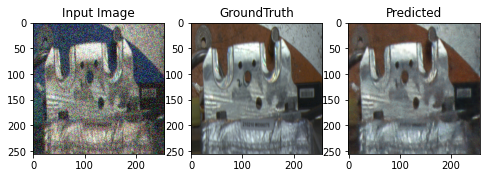

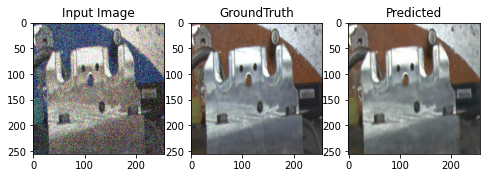

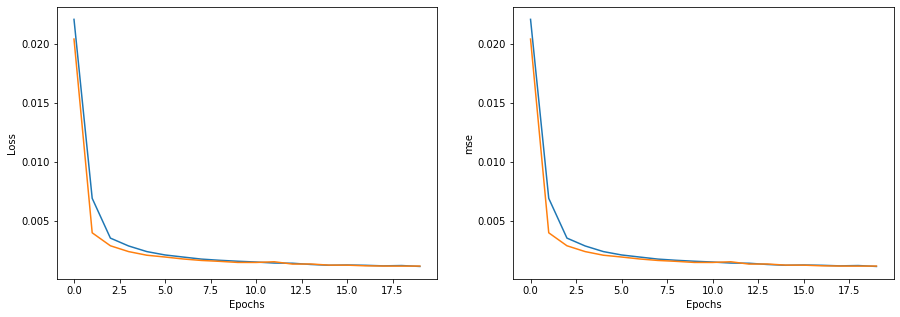

In [24]:
plot_training_history(history)

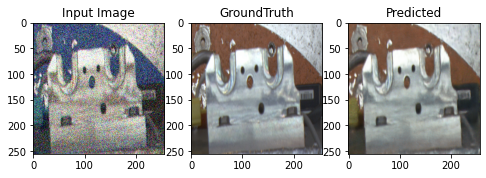

0

In [27]:
noise_img, org_img = get_sample_image(val_noised,val_denoised)

value1 = PSNR(org_img, noise_img)
pred_img = vgg_unet.predict(np.expand_dims(noise_img,axis=0))

value2 = PSNR(org_img, pred_img)
display_predictions(np.reshape(pred_img,(256,256,3)),org_img,noise_img)